### Recap from previous Lab

* We "closed the loop" on our first MultiLayer Perceptron (MLP), exploring how the training routine is implemented in PyTorch (PT):

    * we saw how to use built-in loss functions in PT and we learned how to construct custom losses based upon tensor methods
    * moreover, we also saw how to use vanilla Stochastic Gradient Descent (SGD) in conjunction with backpropagation to enable the parameters updating in our MLP

### Agenda for today

* The main topic of our lecture is **regularization**
* First of all, though, we will implement a framework for monitoring the parameters during training (the so called *trajectory*), a simple research exercize
* On to regularization, we will see how to utilize various way to infuse regularization into our MLP training, still with an eye on the trajectory:

  * L2 regularization (aka *weight decay*)
  * dropout
  * regularization layers
  

### Examining parameters mid-training – the trajectory

We already covered how to save the "snapshot" of the parameters via the `state_dict` during the previous Lab.
We can use the same method to recover the trajectory during our training, although a more useful alternative is `model.named_parameters()`

In [1]:
import torch
import os
from torch import nn
from matplotlib import pyplot as plt


from scripts import mnist
from scripts.train_utils import accuracy, AverageMeter

Let us quickly recover the stuff we implemented during Lab 2

In [4]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flat = nn.Flatten()
        self.h1 = nn.Linear(28*28, 16)
        self.h2 = nn.Linear(16, 32)
        self.h3 = nn.Linear(32, 24)
        self.out = nn.Linear(24, 10)
    
    def forward(self, X, activ_hidden=nn.functional.relu):
        out = self.flat(X)
        out = activ_hidden(self.h1(out))
        out = activ_hidden(self.h2(out))
        out = activ_hidden(self.h3(out))
        out = self.out(out)
        return out

Let's see what `model.named_parameters()` is and how to use it:

In [20]:
model = MLP()
for name, param in model.named_parameters():
    print(name, "\t", param.shape)

h1.weight 	 torch.Size([16, 784])
h1.bias 	 torch.Size([16])
h2.weight 	 torch.Size([32, 16])
h2.bias 	 torch.Size([32])
h3.weight 	 torch.Size([24, 32])
h3.bias 	 torch.Size([24])
out.weight 	 torch.Size([10, 24])
out.bias 	 torch.Size([10])


We can now add a small piece of code to our `train_epoch` from last Lab to implement the tracking of the trajectory: more specifically, we're interested in the L2-norm of the parameters during each training iteration.

NB:
* Each **epoch** is composed of **training iterations**:
  * a training iteration coincides with the forward/backward pass on a single batch
  * an epoch is completed when the whole of the dataset has been seen from the network during training. After an epoch has ended, we reshuffle the batches and begin a new epoch

As we can see above, parameters are stored in a (lazy) list of tuples. If we want to calculate the norm, we can't do it on such structure.
What we need to do is:
* "flatten" all the list in a single tensor (a vector)
  * first, we must create this tensor, and to do so we have to know the number of parameters that we will need to fit into it
* calculate the norm of this vector

In addition to the norm of the parameters, we're interested in the **norm of the gradients**.

Gradients of a layer may be accessed via `tensor.grad` where `tensor` is the tensor associated to the parameters of a given layer.

Let's try to call it now on our `named_parameters`:

In [21]:
for name, param in model.named_parameters():
    print(name, "\t", param.grad)

h1.weight 	 None
h1.bias 	 None
h2.weight 	 None
h2.bias 	 None
h3.weight 	 None
h3.bias 	 None
out.weight 	 None
out.bias 	 None


We see that all the gradients are `None`

**Q**: who knows why?

In [93]:
def get_params_and_gradients_norm(named_parameters):
    square_norms_params = []
    square_norms_grads = []

    for _, param in named_parameters:

        # Q: what is this and why did I write it here?
        if param.requires_grad:
            square_norms_params.append((param ** 2).sum())
            square_norms_grads.append((param.grad ** 2).sum())
    
    norm_params = sum(square_norms_params).sqrt().item()
    norm_grads = sum(square_norms_grads).sqrt().item()

    return norm_params, norm_grads

In [81]:
def train_epoch(model, dataloader, loss_fn, optimizer, loss_meter, performance_meter, performance, trajectory): # note: I've added a generic performance to replace accuracy
    for X, y in dataloader:
        # 1. reset the gradients previously accumulated by the optimizer
        #    this will avoid re-using gradients from previous loops
        optimizer.zero_grad() 
        # 2. get the predictions from the current state of the model
        #    this is the forward pass
        y_hat = model(X)
        # 3. calculate the loss on the current mini-batch
        loss = loss_fn(y_hat, y)
        # 4. execute the backward pass given the current loss
        loss.backward()
        # 5. update the value of the params
        optimizer.step()
        # 6. calculate the accuracy for this mini-batch
        acc = performance(y_hat, y)
        # 7. update the loss and accuracy AverageMeter
        loss_meter.update(val=loss.item(), n=X.shape[0])
        performance_meter.update(val=acc, n=X.shape[0])

        if trajectory is not None:

            params_norm, gradients_norm = get_params_and_gradients_norm(model.named_parameters())
            trajectory["parameters"].append(params_norm)
            trajectory["gradients"].append(gradients_norm)

def train_model(model, dataloader, loss_fn, optimizer, num_epochs, checkpoint_loc=None, checkpoint_name="checkpoint.pt", performance=accuracy, trajectory=None): # note: I've added a generic performance to replace accuracy and an object where to store the trajectory

    # create the folder for the checkpoints (if it's not None)
    if checkpoint_loc is not None:
        os.makedirs(checkpoint_loc, exist_ok=True)
    
    model.train()

    # epoch loop
    for epoch in range(num_epochs):
        loss_meter = AverageMeter()
        performance_meter = AverageMeter()

        train_epoch(model, dataloader, loss_fn, optimizer, loss_meter, performance_meter, performance, trajectory)

        print(f"Epoch {epoch+1} completed. Loss - total: {loss_meter.sum} - average: {loss_meter.avg}; Performance: {performance_meter.avg}")

        # produce checkpoint dictionary -- but only if the name and folder of the checkpoint are not None
        if checkpoint_name is not None and checkpoint_loc is not None:
            checkpoint_dict = {
                "parameters": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch
            }
            torch.save(checkpoint_dict, os.path.join(checkpoint_loc, checkpoint_name))

    return loss_meter.sum, performance_meter.avg, trajectory

def test_model(model, dataloader, performance=accuracy, loss_fn=None):
    # create an AverageMeter for the loss if passed
    if loss_fn is not None:
        loss_meter = AverageMeter()
    
    performance_meter = AverageMeter()

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            y_hat = model(X)
            loss = loss_fn(y_hat, y) if loss_fn is not None else None
            acc = performance(y_hat, y)
            if loss_fn is not None:
                loss_meter.update(loss.item(), X.shape[0])
            performance_meter.update(acc, X.shape[0])
    # get final performances
    fin_loss = loss_meter.sum if loss_fn is not None else None
    fin_perf = performance_meter.avg
    print(f"TESTING - loss {fin_loss if fin_loss is not None else '--'} - performance {fin_perf}")
    return fin_loss, fin_perf

In [82]:
minibatch_size_train = 256
minibatch_size_test = 512

trainloader, testloader, trainset, testset = mnist.get_data(batch_size_train=minibatch_size_test, batch_size_test=minibatch_size_test)

In [83]:
learn_rate = 0.1
num_epochs = 5

model = MLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate)

trajectory = {"parameters": [], "gradients": []}

Train the MLP:

In [84]:
train_loss, train_acc, trajectory = train_model(model, trainloader, loss_fn, optimizer, num_epochs, trajectory=trajectory)

Epoch 1 completed. Loss - total: 66095.56457328796 - average: 1.1015927428881327; Performance: 0.6454833333651224
Epoch 2 completed. Loss - total: 21945.435737609863 - average: 0.3657572622934977; Performance: 0.8919333333015442
Epoch 3 completed. Loss - total: 16969.264185905457 - average: 0.2828210697650909; Performance: 0.9169000000317892
Epoch 4 completed. Loss - total: 14510.959329128265 - average: 0.24184932215213775; Performance: 0.9281499999682109
Epoch 5 completed. Loss - total: 12942.454675674438 - average: 0.21570757792790732; Performance: 0.9359666666348775


Now we can plot the norms

In [102]:
def plot_trajectory(trajectory):
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
    ax1.plot(trajectory["parameters"])
    ax1.set_title("Norm of parameters")
    ax2.plot(trajectory["gradients"])
    ax2.set_title("Norm of gradients")
    plt.show()

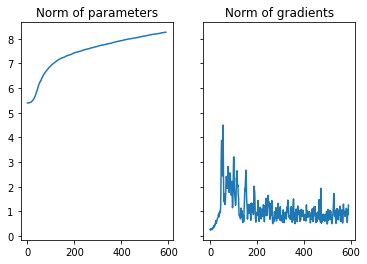

In [103]:
plot_trajectory(trajectory)

We can see a similar trend to what [3](https://arxiv.org/abs/2002.10365) observed:

1. in the very first iterations, gradients are very large and parameters quickly grow
2. gradients quickly diminishes, while parameters growth tends to slow down
3. gradients reach a "stationary state" (with some noise added), while parameters grow even slower

5 epochs of training is very little. If you want (_not a homework_), you may try increasing the number of epochs and see what happens.

of course, the analysis in [3](https://arxiv.org/abs/2002.10365) is much finer than ours and considers much more quantities and experiments than ours.

### Regularization

Regularization in DL comes in the form of different tools. We can have:

1. Penalty terms in loss functions (e.g. L1 and L2 norm regularization) which introduce bias in our parameters by actively reducing the magnitude of some weights:
    * L1 norm regularization is also called LASSO regularization
    * L2 norm regularization is also called Ridge regularization or **weight decay**
    * they were originally implemented in linear regression models as a way to infuse *inductive bias* in models originally thought to rely on the complete unbiasedness on training data
2. Normalization layers which normalize the incoming information s.t. their mean is zero and standard deviation one. It comes in different flavors:
    * batch normalization or batchnorm (the most common technique)
    * group normalization or groupnorm
    * there are more possibilities, for additional info on these, please check [this lecture by Aaron Defazio, NYU](https://atcold.github.io/pytorch-Deep-Learning/en/week05/05-2/)
3. Dropout, a technique [patented by Google](https://patents.google.com/patent/US9406017B2/en) which consists in randomly *dropping* some neurons from a given layer to prevent overfitting.
4. Early stopping, which we'll see later on during this Lab.

#### Weight decay or L2 norm/Ridge regularization

Weight Decay (WD) is a simple technique which *appends* a penalty term to the loss function equation. The term is based upon the L2 norm of the weights.

Given our original loss function $\mathcal{L}_0 (\hat{y}, y)$ and our parameter vector $\Theta$, our new loss will be:

$\mathcal{L}_0 (\hat{y}, y) + \lambda \cdot \vert\vert \Theta \vert\vert_2$

the parameter $\lambda$ (also called weight decay) controls the strenght of the regularization. $\lambda$ too high means that the model will not concentrate well enough on the original objective ($\mathcal{L}_0$), hence it will not perform well. Usually, good values form $\lambda$ fall into the interval $[5\cdot 10^{-4}, 1\cdot 10^{-4}]$.

In PT, instead of inserting our penalty term in the loss function, we specify the weight decay parameter in our optimizer:

In [13]:
weight_decay = 5e-4
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate, weight_decay=weight_decay)

#### L1 norm regularization

L1 norm regularization is analogous to weight decay. The equation is:

$\mathcal{L}_0 (\hat{y}, y) + \lambda \cdot \vert\vert \Theta \vert\vert_1$

where $\vert\vert x \vert\vert_1 = \sum_{j=1}^d \vert x_j \vert$

unlike weight decay, to my knowledge PT does not provide a built-in for L1 reg. You need to define a custom loss function for this task (**homework**).

#### batchnorm

Batch Normalization operates in such a way that the mean and standard deviation of the incoming batches of data are approximately 0 and 1 respectively.

The ultimate goal of batchnorm is not to normalize each batch, but estimate one vector for mean (a running mean) and one for std (a running std) for the whole dataset and to normalize w.r.t. these. So, these become new parameters of the network. They are not adjusted via backprop but they get adjusted each time the layer *sees* another batch of data.

![](https://miro.medium.com/max/474/1*QQ2Q5rVBtLv7b3yGhO0flg.png)

*picture from [towardsdatascience.com](https://towardsdatascience.com/batch-normalisation-explained-5f4bd9de5feb)*

When the network is evaluated on test data, the running mean and std must not be adjusted, hence PT has implemented a "switch", which we saw during the previous Lab, to tell the network when to adjust and not adjust these two parameters. The switch is triggered via `model.train()` and `model.eval()` (or equivalently `model.train(False)`).

In PT, the batch normalization is found as a regular layer under within the `torch.nn` library

In [16]:
class MLP_BN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 16),
            nn.ReLU(),

            nn.BatchNorm1d(num_features=16), # we specify the dimensionality of the incoming data
            nn.Linear(16, 32),
            nn.ReLU(),

            nn.BatchNorm1d(num_features=32),
            nn.Linear(32, 24),
            nn.ReLU(),

            nn.BatchNorm1d(num_features=24),
            nn.Linear(24, 10)
        )


    def forward(self, X):
        return self.layers(X)

**Q** (for the most skilled students): why didn't we apply batchnorm for the first layer?

By peeking at the PT docs, we can see that actually the batchnorm layers have much more hyperparameters which we can play with if we wanted to:

![](img/bn_docs.jpg)

*from [PyTorch docs](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)*

In addition to what we say till now, there is still some debate in the DL community on whether batchnorm or other normalization techniques help optimization. The claims in the original paper [1](https://arxiv.org/abs/1502.03167) of "reducing internal covariate shift" was confuted in successive works such as [2](https://arxiv.org/abs/1805.11604.pdf), which claims that it "makes the optimization landscape significantly smoother". Another things to consider is that, since the data is distributed in a small intervall around 0, there's also a better numerical stability added.

#### Dropout

Dropout acts by removing (i.e. *zeroing-out*) a random subset of the neurons in a given layer for each forward pass.

It has one hyperparameter ($p$), which is the fraction of neurons to be dropped out.

During training, each time a layer with backprop produces an output, a fraction $p$ of that output gets discarded. This helps in such a way that co-dependence between neurons gets *forgotten* by the network. To say it in simple terms, it forces each neuron to be independent from the output of other neurons within the same layer.

For the same reason as in batchnorm, since dropout has to apply only during training, we must be careful in activating the switch `model.eval()` when testing our network.

In PT, we find Dropout as a module of `torch.nn`. Instead of placing if *before* the layer (as in batchnorm), we place it *after* the layer (the reason being, the layer produces an output, a portion $p$ of that output gets discarded).

In [98]:
class MLP_BN_Drop(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 16),
            nn.ReLU(),

            nn.BatchNorm1d(num_features=16),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Dropout(p=.2), # we add a dropout here. it's referred to the previous layer (with 32 neurons)

            nn.BatchNorm1d(num_features=32),
            nn.Linear(32, 24),
            nn.ReLU(),

            nn.BatchNorm1d(num_features=24),
            nn.Linear(24, 10)
        )


    def forward(self, X):
        return self.layers(X)

In [104]:
model = MLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate)

trajectory_reg = {"parameters": [], "gradients": []}

In [105]:
train_loss, train_acc, trajectory = train_model(model, trainloader, loss_fn, optimizer, num_epochs, trajectory=trajectory_reg)

Epoch 1 completed. Loss - total: 77149.27393913269 - average: 1.2858212323188782; Performance: 0.5637666666666666
Epoch 2 completed. Loss - total: 23644.09912252426 - average: 0.3940683187087377; Performance: 0.8812999999682108
Epoch 3 completed. Loss - total: 17435.458475112915 - average: 0.29059097458521527; Performance: 0.9130500000317892
Epoch 4 completed. Loss - total: 14956.619361400604 - average: 0.24927698935667675; Performance: 0.9248499999682108
Epoch 5 completed. Loss - total: 13526.892585754395 - average: 0.22544820976257324; Performance: 0.93245


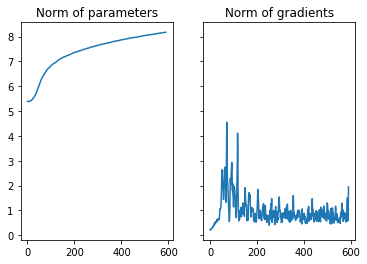

In [106]:
plot_trajectory(trajectory_reg)

**References**

[1](https://arxiv.org/abs/1502.03167) Ioffe, S., & Szegedy, C. (2015, June). Batch normalization: Accelerating deep network training by reducing internal covariate shift. In International conference on machine learning (pp. 448-456). PMLR.

[2](https://arxiv.org/abs/1805.11604) Santurkar, S., Tsipras, D., Ilyas, A., & Madry, A. (2018). How does batch normalization help optimization?. arXiv preprint arXiv:1805.11604.

[3](https://arxiv.org/abs/2002.10365) Frankle, J., Schwab, D. J., & Morcos, A. S. (2020). The early phase of neural network training. arXiv preprint arXiv:2002.10365.